## 1. Settings

## 1.1 Setting up the environment

In [194]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

## 1.2 Setting up the molecular systems for training

In [195]:
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_shells': torch.tensor([1.7342, 4.8584, 0.7037, 0.7037]),
           'dipole':torch.tensor([ 0.0000e+00, -6.4284e-01, -3.3307e-16])
           }

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

## 1.3 Setting up the model for training

In [196]:
#Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 1000
lr = 0.008

## 1.4 Setting up the DFTB calculator

## 1.4.1 Input the molecular systems

In [197]:
device = torch.device('cpu')

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()

## 1.4.2 Loading of the DFTB parameters into their associated feed objects

In [198]:
# Load all the necessary feed models
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

## 1.4.3 Constructing the SCC-DFTB calculator

In [199]:
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)


## 2. Data preparation

## 2.1 Bypassing the nn.Module.__setattr__ method that was causing the error

In [200]:
original_h = h_feed._on_sites["1"].clone()
original_o = h_feed._on_sites["8"].clone()

slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

torch.manual_seed(4)  # Set random seed for reproducibility

# SOLUTION: Work around the nn.Module restriction by using object.__setattr__
# This bypasses PyTorch's restriction on dictionary assignment

# First, let's see what type of object h_feed is and what _on_sites contains
print("h_feed type:", type(h_feed))
print("_on_sites type:", type(h_feed._on_sites))
print("Original _on_sites keys:", list(h_feed._on_sites.keys()))

# Method 1: Use object.__setattr__ to bypass PyTorch's restrictions
new_on_sites = {
    "1": torch.zeros(9, requires_grad=True, dtype=torch.float64),
    "8": torch.zeros(9, requires_grad=True, dtype=torch.float64)
}

# This bypasses the nn.Module.__setattr__ method that was causing the error
object.__setattr__(h_feed, '_on_sites', new_on_sites)

print("Successfully replaced _on_sites!")
print("New _on_sites type:", type(h_feed._on_sites))
print("New _on_sites keys:", list(h_feed._on_sites.keys()))
print("H tensor requires_grad:", h_feed._on_sites["1"].requires_grad)
print("O tensor requires_grad:", h_feed._on_sites["8"].requires_grad)

h_feed type: <class 'tbmalt.physics.dftb.feeds.SkFeed'>
_on_sites type: <class 'torch.nn.modules.container.ParameterDict'>
Original _on_sites keys: ['1', '8']
Successfully replaced _on_sites!
New _on_sites type: <class 'dict'>
New _on_sites keys: ['1', '8']
H tensor requires_grad: True
O tensor requires_grad: True


## 3. Model training

In [201]:
# Create 3 individual trainable parameters
torch.manual_seed(2)  # Set random seed for reproducibility
h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

# Get the 3 specific parameters for optimization
params = [h_param, o_param_a, o_param_b]

In [202]:
optimizer = torch.optim.SGD(params, lr=lr)

In [203]:
# Training loop
loss_list = []
for epoch in range(number_of_epochs):
    optimizer.zero_grad()
    print('epoch', epoch)
    # Now we can update the tensors as you originally intended
    # For hydrogen (Z=1)
    h_feed._on_sites["1"] = torch.cat([h_param.view(1), slice_h])
    
    # For oxygen (Z=8)
    h_feed._on_sites["8"] = torch.cat([o_param_a.view(1), o_param_b.view(1).repeat(3), slice_o])

    # Run DFTB calculation
    dftb_calculator(geometry, orbs, grad_mode="direct")
    
    # Calculate loss
    energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
    mulliken_loss = mse_loss(dftb_calculator.q_final_shells, targets['q_final_shells'])
    dipole_loss = mse_loss(dftb_calculator.dipole, targets['dipole'])
    loss = energy_loss + mulliken_loss
    
    # Backward pass
    loss.backward(retain_graph=True)
    
    # Update parameters
    optimizer.step()
    print("loss:",loss)
    # Record loss
    loss_list.append(loss.item())
    

# Print final parameters
print("="*50)
print("Final Loss", loss_list[-1])
print("Original H on-site parameters:", original_h)
print("Original O on-site parameters:", original_o)

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")


epoch 0
loss: tensor(6.6180, grad_fn=<AddBackward0>)
epoch 1
loss: tensor(1.8559, grad_fn=<AddBackward0>)
epoch 2
loss: tensor(0.9793, grad_fn=<AddBackward0>)
epoch 3
loss: tensor(0.6701, grad_fn=<AddBackward0>)
epoch 4
loss: tensor(0.5431, grad_fn=<AddBackward0>)
epoch 5
loss: tensor(0.4817, grad_fn=<AddBackward0>)
epoch 6
loss: tensor(0.4459, grad_fn=<AddBackward0>)
epoch 7
loss: tensor(0.4209, grad_fn=<AddBackward0>)
epoch 8
loss: tensor(0.4012, grad_fn=<AddBackward0>)
epoch 9
loss: tensor(0.3846, grad_fn=<AddBackward0>)
epoch 10
loss: tensor(0.3701, grad_fn=<AddBackward0>)
epoch 11
loss: tensor(0.3573, grad_fn=<AddBackward0>)
epoch 12
loss: tensor(0.3459, grad_fn=<AddBackward0>)
epoch 13
loss: tensor(0.3356, grad_fn=<AddBackward0>)
epoch 14
loss: tensor(0.3263, grad_fn=<AddBackward0>)
epoch 15
loss: tensor(0.3179, grad_fn=<AddBackward0>)
epoch 16
loss: tensor(0.3101, grad_fn=<AddBackward0>)
epoch 17
loss: tensor(0.3030, grad_fn=<AddBackward0>)
epoch 18
loss: tensor(0.2964, grad_fn=

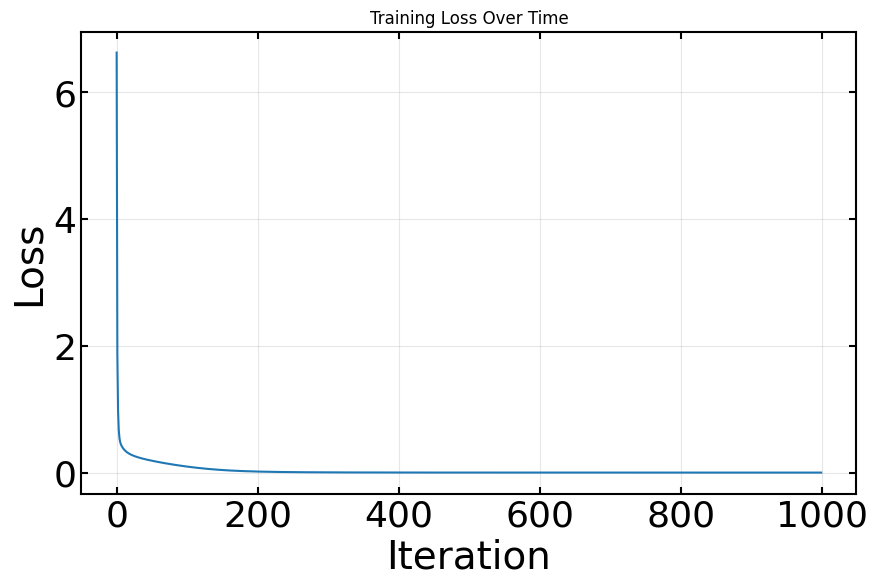

In [204]:
# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.title("Training Loss Over Time")
plt.grid(True, alpha=0.3)
plt.show()
